In [ ]:
# This is the original code that ran with 2013 data
# The models preformed very poorly due to imbalanced data, however keep this to be used as a benchmark 

In [1]:
#Load libaries
import os
import pandas as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt 
from pydotplus import graph_from_dot_data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC 
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')
            

In [2]:
#Load datasets
data = pd.read_csv('2013-data-output.csv')   

# Cleaning the data

In [3]:
data.head()

,Unnamed: 0,Date,Longitude,Latitude,EVI,TA,LST,Wind,Fire
0,0,2013-01-01,-123.754626,41.994986,3308,5,0,21,0
1,1,2013-01-01,-123.750462,41.994986,3477,5,0,21,0
2,2,2013-01-01,-123.746298,41.994986,3477,5,0,21,0
3,3,2013-01-01,-123.742134,41.994986,4475,5,0,21,0
4,4,2013-01-01,-123.737970,41.994986,3000,5,13707,21,0


In [4]:
data = data[data['Date'] != '2013-01-01'] #Dropping the first day that has missing LST data

In [5]:
data.head()

,Unnamed: 0,Date,Longitude,Latitude,EVI,TA,LST,Wind,Fire
267853,267853,2013-01-02,-123.754626,41.994986,3375,5,13639,26,0
267854,267854,2013-01-02,-123.750462,41.994986,3524,5,13639,26,0
267855,267855,2013-01-02,-123.746298,41.994986,3524,5,13639,26,0
267856,267856,2013-01-02,-123.742134,41.994986,4460,5,13639,26,0
267857,267857,2013-01-02,-123.737970,41.994986,3115,5,13677,26,0


In [6]:
if 'Date' in data:
    data = data.drop(['Date', 'Longitude', 'Latitude'], axis = 1)
data.head()

,Unnamed: 0,EVI,TA,LST,Wind,Fire
267853,267853,3375,5,13639,26,0
267854,267854,3524,5,13639,26,0
267855,267855,3524,5,13639,26,0
267856,267856,4460,5,13639,26,0
267857,267857,3115,5,13677,26,0


In [7]:
data.TA.value_counts()

TA
 5      88881052
 4       7813898
 3        777155
 9         12990
 8          6266
-999        6188
 7           919
 6            24
Name: count, dtype: int64

In [8]:
data = data[data.TA !=-999]
data = data[data.TA != 3]
data = data[data.TA !=4]

In [9]:
data.TA.value_counts()

TA
5    88881052
9       12990
8        6266
7         919
6          24
Name: count, dtype: int64

In [10]:
Count=data.Fire.value_counts() #count target feature 
Count

Fire
0    88827833
1       73418
Name: count, dtype: int64

In [11]:
print('Proportion:', round(Count[0] / Count[1], 2), ': 1')


Proportion: 1209.89 : 1


In [12]:
data.LST.value_counts()

LST
0        112921
15062     56627
15060     56322
15027     56241
15084     56220
          ...  
17283         1
12859         1
16890         1
12797         1
16886         1
Name: count, Length: 3990, dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88901251 entries, 267853 to 97766344
Data columns (total 6 columns):
 #   Column      Dtype
---  ------      -----
 0   Unnamed: 0  int64
 1   EVI         int64
 2   TA          int64
 3   LST         int64
 4   Wind        int64
 5   Fire        int64
dtypes: int64(6)
memory usage: 4.6 GB


In [14]:
data.describe() # Statistic summary

,Unnamed: 0,EVI,TA,LST,Wind,Fire
count,8.890125e+07,8.890125e+07,8.890125e+07,8.890125e+07,8.890125e+07,8.890125e+07
mean,5.008608e+07,2.750837e+03,5.000817e+00,1.471818e+04,2.360307e+01,8.258376e-04
std,2.750768e+07,9.846965e+02,5.489236e-02,7.821603e+02,1.537075e+01,2.872552e-02
min,2.678530e+05,-3.000000e+03,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.711508e+07,2.072000e+03,5.000000e+00,1.429400e+04,1.200000e+01,0.000000e+00
50%,5.057289e+07,2.757000e+03,5.000000e+00,1.473800e+04,2.100000e+01,0.000000e+00
75%,7.358747e+07,3.425000e+03,5.000000e+00,1.516000e+04,3.100000e+01,0.000000e+00
max,9.776634e+07,9.256000e+03,9.000000e+00,1.758000e+04,2.550000e+02,1.000000e+00


In [15]:
data.isnull().sum() # return number of missing value for each column

Unnamed: 0    0
EVI           0
TA            0
LST           0
Wind          0
Fire          0
dtype: int64

In [16]:
data.drop(columns='Fire').skew(axis = 0) # return skewness of each independent feature

Unnamed: 0    -0.037574
EVI           -0.031348
TA            68.501279
LST           -8.390453
Wind           1.319618
dtype: float64

# Applying models and evalution

## Downsampling Majority Dataset 

## Splitting Data & Scaling Data
We are making the data have similar range for the machine model to not weight one varible bigger then the other

In [17]:
# Getting the X & Y
X = data.drop(columns=['Fire']).values
Y = data['Fire'].values

scale = StandardScaler()
X = scale.fit_transform(X) 

tempX = pd.DataFrame(X)
tempX.head()
tempY = pd.DataFrame(Y)
tempY.head()

,0
0,0
1,0
2,0
3,0
4,0


In [18]:
# 20% test 80% training data             
X_train, X_test, y_train, y_test, = train_test_split(X, Y, test_size=0.2,random_state = 42)

                                                         # 0.25 x 0.8 = 0.2 for validation data
X_train, X_val, y_train, y_val, = train_test_split(X_train, y_train, test_size=0.25,random_state = 16) 

# Logistic Regression

In [19]:


# Instantiate
LR = LogisticRegression(C=0.01, penalty= 'l2', solver= 'liblinear')
# Fit
LR = LR.fit(X_train, y_train)
LR.score(X_train,y_train)

# Predictions on the test dataset
LR_pred = pd.DataFrame(LR.predict(X_test))

# Probabilities on the test dataset
probs = pd.DataFrame(LR.predict_proba(X_test))

print(metrics.classification_report(y_test, LR_pred))   #Logistic Regression 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00  17765364
           1       0.00      0.00      0.00     14887

    accuracy                           1.00  17780251
   macro avg       0.50      0.50      0.50  17780251
weighted avg       1.00      1.00      1.00  17780251



Text(0.5, 15.0, 'Predicted label')

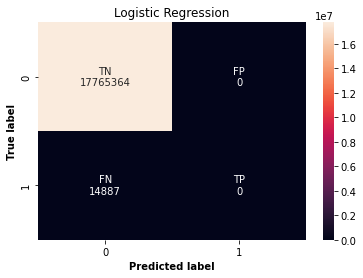

In [20]:
LR_cm = confusion_matrix(y_test, LR_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                LR_cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(LR_cm,annot=labels,fmt='')
plt.title('Logistic Regression')
plt.ylabel('True label',fontweight='bold')
plt.xlabel('Predicted label',fontweight='bold')
#plt.savefig('C:/Users/kayle/Desktop/LR_confmatrix',dpi=300,bbox_inches='tight', transparent=True)

In [21]:
# get prediction for X_val
new_output = LR.predict(X_val)
np.unique(new_output,return_counts=True)

(array([0]), array([17780250]))

In [22]:
np.unique(y_val,return_counts=True)

(array([0, 1]), array([17765539,    14711]))

# Gaussian Naive Bayes

In [23]:
#NB = MultinomialNB()
NB= GaussianNB(var_smoothing= 0.12328467394420659)
NB.fit(X_train, y_train)

NB_pred = pd.DataFrame(NB.predict(X_test))

print(metrics.classification_report(y_test, NB_pred))   #Gaussian Naive Bayes

              precision    recall  f1-score   support

           0       1.00      1.00      1.00  17765364
           1       0.00      0.00      0.00     14887

    accuracy                           1.00  17780251
   macro avg       0.50      0.50      0.50  17780251
weighted avg       1.00      1.00      1.00  17780251



Text(0.5, 15.0, 'Predicted label')

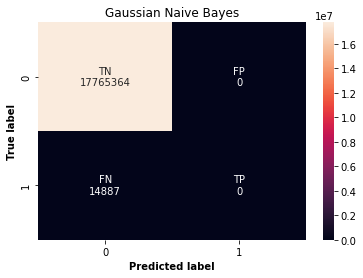

In [24]:
NB_cm = confusion_matrix(y_test, NB_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                NB_cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(NB_cm,annot=labels,fmt='')
plt.title('Gaussian Naive Bayes')
plt.ylabel('True label',fontweight='bold')
plt.xlabel('Predicted label',fontweight='bold')
#plt.savefig('C:/Users/kayle/Desktop/GaussianNB_confmatrix',dpi=300,bbox_inches='tight', transparent=True)

In [25]:
# get prediction for X_val
new_output = NB.predict(X_val)
np.unique(new_output,return_counts=True)

(array([0]), array([17780250]))

In [26]:
np.unique(y_val,return_counts=True)

(array([0, 1]), array([17765539,    14711]))

# K - Nearest Neighbors

In [27]:
KNN = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 13, weights='uniform')  
KNN.fit(X_train, y_train)

KNN_pred = pd.DataFrame(KNN.predict(X_test))

print(metrics.classification_report(y_test, KNN_pred))   #K-NearestNeighbors

KeyboardInterrupt: 

In [ ]:
KNN_cm = confusion_matrix(y_test, KNN_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                KNN_cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(KNN_cm, annot=labels, fmt='')
plt.title('K-Nearest Neighbors')
plt.ylabel('True label',fontweight='bold')
plt.xlabel('Predicted label',fontweight='bold')
#plt.savefig('C:/Users/kayle/Desktop/KNN_confmatrix',dpi=300,bbox_inches='tight', transparent=True)

In [ ]:
# get prediction for X_val
new_output = KNN.predict(X_val)
np.unique(new_output,return_counts=True)

In [ ]:
np.unique(y_val,return_counts=True)

In [ ]:
# define input
new_input =  X # original dataset
# get prediction for new input
new_output = KNN.predict(new_input)
np.unique(new_output,return_counts=True)

In [ ]:
data.Class.value_counts()

# Random Forest

In [ ]:
#Create a RandomForest Classifier
RF = RandomForestClassifier(max_features = 'sqrt', n_estimators = 100)                      

#Train the model using the training sets y_pred=clf.predict(X_test)
RF.fit(X_train,y_train)

RF_pred = RF.predict(X_test) 

print(metrics.classification_report(y_test, RF_pred))   #Random Forest

In [ ]:
RF_cm = confusion_matrix(y_test, RF_pred)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                RF_cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(RF_cm,annot=labels,fmt='')
plt.title('RandomForest')
plt.ylabel('True label',fontweight='bold')
plt.xlabel('Predicted label',fontweight='bold')

#plt.savefig('C:/Users/kayle/Desktop/RF_confmatrix',dpi=300,bbox_inches='tight', transparent=True)

In [ ]:
# get prediction for X_val
new_output = RF.predict(X_val)
np.unique(new_output,return_counts=True)

In [ ]:
np.unique(y_val,return_counts=True)

# Suport Vector Machine

In [ ]:
# Fitting Kernel SVM to the Training set                            
SVM = SVC(C= 10, gamma= 'scale', kernel= 'rbf')
SVM.fit(X_train,y_train)

#Predicting the Test Set
SVM_pred = SVM.predict(X_test)
print(classification_report(y_test, SVM_pred))

In [ ]:
#making confusing matrix
SVM_cm = confusion_matrix(y_test, SVM_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                SVM_cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(SVM_cm,annot=labels,fmt='')
plt.title('Support Vector Machine')
plt.ylabel('True label',fontweight='bold')
plt.xlabel('Predicted label',fontweight='bold')
#plt.savefig('C:/Users/kayle/Desktop/SVM_confmatrix',dpi=300,bbox_inches='tight', transparent=True)

In [ ]:
# get prediction for X_val
new_output = SVM.predict(X_val)
np.unique(new_output,return_counts=True)

In [ ]:
np.unique(y_val,return_counts=True)

# Neural Networks

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
#mpl = MLPClassifier(activation= 'tanh', alpha= 0.0001, hidden_layer_sizes= (20,), learning_rate= 'adaptive', solver= 'sgd')
mlp.fit(X_train,y_train)

NN_pred_train = mlp.predict(X_train)
NN_pred_test = mlp.predict(X_test)

In [ ]:
print(classification_report(y_test,NN_pred_test))

In [ ]:
#making confusing matrix
NN_cm = confusion_matrix(y_test, NN_pred_test)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                NN_cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(NN_cm,annot=labels,fmt='')
plt.title('Neural Networks')
plt.ylabel('True label',fontweight='bold')
plt.xlabel('Predicted label',fontweight='bold')
#plt.savefig('C:/Users/kayle/Desktop/NN_confmatrix',dpi=300,bbox_inches='tight', transparent=True)

In [ ]:
# get prediction for X_val
new_output = mlp.predict(X_val)
np.unique(new_output,return_counts=True)

In [ ]:
np.unique(y_val,return_counts=True)

In [ ]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X, Y)

In [ ]:
print('Best parameters found:\n', clf.best_params_)